In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

DATASET_PATH = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data"
os.listdir(DATASET_PATH)


['SpaceNet.FLARE.imam_alam']

In [2]:
DATASET_PATH = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"
os.listdir(DATASET_PATH)


['planet',
 'galaxy',
 'black hole',
 'asteroid',
 'comet',
 'star',
 'constellation',
 'nebula']

In [3]:
class_counts = {}

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    class_counts[cls] = len(os.listdir(cls_path))

class_counts


{'planet': 1472,
 'galaxy': 3984,
 'black hole': 656,
 'asteroid': 283,
 'comet': 416,
 'star': 3269,
 'constellation': 1552,
 'nebula': 1192}

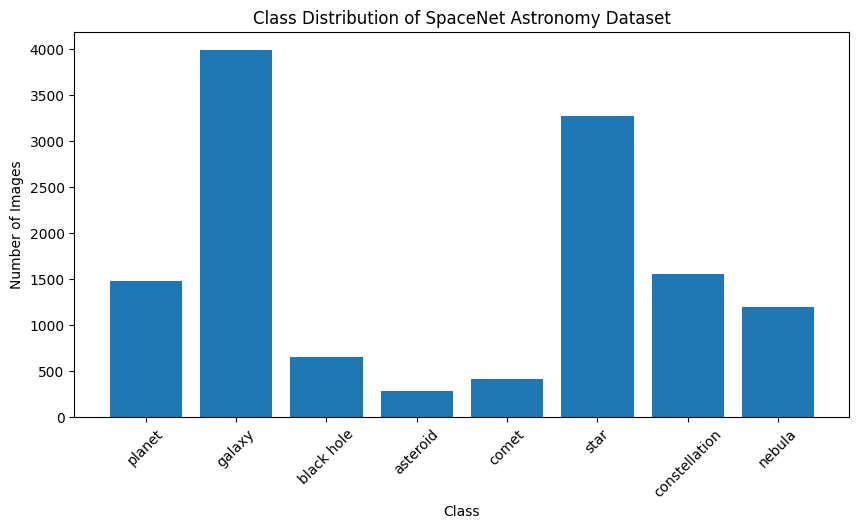

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution of SpaceNet Astronomy Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()



### Class Distribution Analysis

The bar chart above shows a clear class imbalance in the dataset.
Classes such as **galaxy** and **star** have significantly more images
compared to **asteroid** and **comet**, which contain very few samples.

This imbalance can negatively affect model performance by biasing predictions
towards majority classes. To mitigate this, techniques such as data
augmentation, class weighting, or oversampling may be required during training.


In [5]:
from PIL import Image
import numpy as np
import random
import os

# pick one random class
sample_class = random.choice(list(class_counts.keys()))

# pick one random image from that class
sample_image = random.choice(
    os.listdir(os.path.join(DATASET_PATH, sample_class))
)

# load image
img_path = os.path.join(DATASET_PATH, sample_class, sample_image)
img = Image.open(img_path)

# convert image to numpy array
pixels = np.array(img)

pixels.shape, pixels.min(), pixels.max()



((2048, 2048, 3), 4, 255)

### Pixel Value Analysis

A sample image has a shape of (2048, 2048, 3), indicating high-resolution RGB images.
Pixel values range approximately from 4 to 255, which is consistent with standard
8-bit images. This confirms that pixel normalization (scaling values to [0,1])
will be required before model training. Due to large image dimensions, resizing
will be necessary during preprocessing.


In [6]:
pixels.mean(), pixels.std()



(48.170734167099, 32.531611561367136)

### Pixel Statistics

The mean pixel value of a sample image is approximately 48, indicating that
most images are relatively dark, which is expected for astronomical data.
The standard deviation is around 32, suggesting moderate contrast between
foreground celestial objects and the background.

These observations confirm the need for pixel normalization and suggest that
contrast-based data augmentation techniques may be beneficial during training.


In [7]:
img.mode


'RGB'

### Color Channel Analysis

The inspected images are in RGB format with three color channels.
This consistency across images ensures compatibility with standard
convolutional neural networks without requiring channel conversion.


In [9]:
modes = {}

for cls in class_counts:
    img_name = random.choice(os.listdir(os.path.join(DATASET_PATH, cls)))
    img = Image.open(os.path.join(DATASET_PATH, cls, img_name))
    modes[cls] = img.mode

modes


{'planet': 'RGB',
 'galaxy': 'RGB',
 'black hole': 'RGB',
 'asteroid': 'RGB',
 'comet': 'RGB',
 'star': 'RGB',
 'constellation': 'RGB',
 'nebula': 'RGB'}

### Dataset-wide Pixel Consistency Check

A random image from each class was inspected to verify color format.
All classes contain RGB images, confirming consistent channel structure
throughout the dataset. This consistency simplifies preprocessing and
ensures compatibility with standard CNN architectures.


In [10]:
resolutions = []

for cls in class_counts:
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path)[:20]:  # sample 20 images per class
        img = Image.open(os.path.join(cls_path, img_name))
        resolutions.append(img.size)

len(resolutions), resolutions[:5]


UnidentifiedImageError: cannot identify image file '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/galaxy/galaxy_page_8_image_17_aug2_SwinIR_large.png'

In [11]:
from PIL import Image
from PIL import UnidentifiedImageError

resolutions = []
corrupted_images = []

for cls in class_counts:
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path)[:20]:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path)
            resolutions.append(img.size)
        except UnidentifiedImageError:
            corrupted_images.append(img_path)

len(resolutions), len(corrupted_images)


(155, 5)

### Corrupted Image Check

While sampling images across all classes, a small number of files could not
be opened using standard image loaders. Out of 160 sampled images, 5 were
identified as corrupted or unreadable.

This highlights the need for robust preprocessing pipelines that can detect
and skip corrupted images to avoid runtime failures during model training.


In [12]:
unique_resolutions = set(resolutions)
len(unique_resolutions), list(unique_resolutions)[:5]



(1, [(2048, 2048)])

### Image Resolution Consistency

All sampled images share the same resolution of 2048×2048 pixels.
This uniformity simplifies preprocessing, as no conditional resizing
logic is required. However, due to the high resolution, images will
still need to be resized to smaller dimensions before model training
to reduce computational cost.


In [13]:
aspect_ratios = [w / h for (w, h) in resolutions]
min(aspect_ratios), max(aspect_ratios)


(1.0, 1.0)

UnidentifiedImageError: cannot identify image file '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/galaxy/galaxy_page_2_image_14_1_SwinIR_large.png'

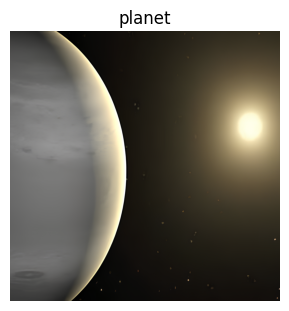

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# make randomness explicit
random.seed(None)

plt.figure(figsize=(16, 8))

classes = os.listdir(DATASET_PATH)

for i, cls in enumerate(classes):
    cls_path = os.path.join(DATASET_PATH, cls)
    
    # pick a random image from the class
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)
    
    img = Image.open(img_path)
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Random Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


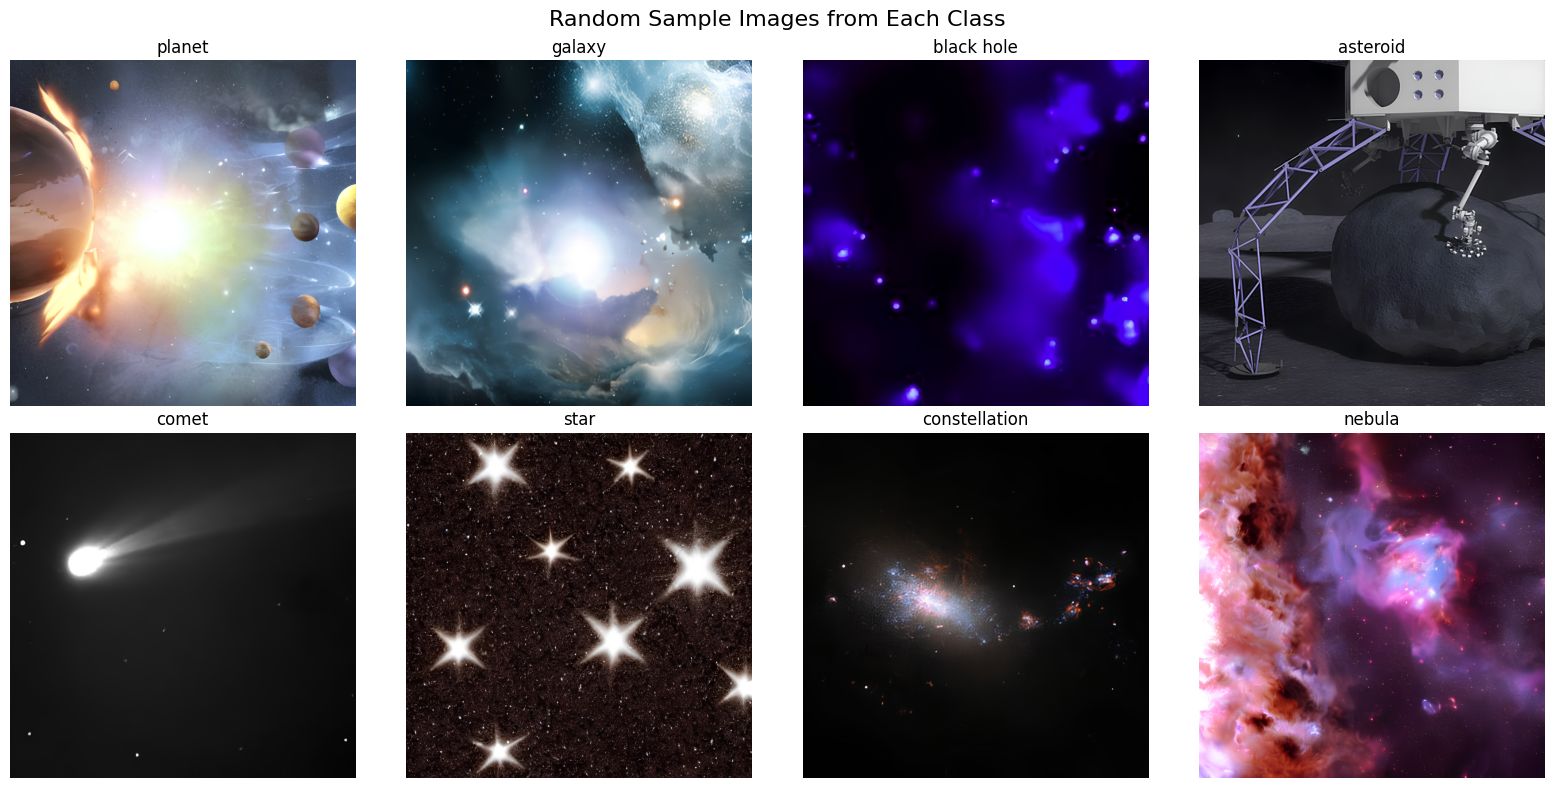

In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

plt.figure(figsize=(16, 8))

classes = os.listdir(DATASET_PATH)

for i, cls in enumerate(classes):
    cls_path = os.path.join(DATASET_PATH, cls)
    images = os.listdir(cls_path)

    img = None
    while img is None:
        img_name = random.choice(images)
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path)
        except UnidentifiedImageError:
            img = None  # try again

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Random Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


### Random Sample Visualization

The figure above shows randomly selected sample images from each class in the
dataset. This visualization confirms that the dataset contains visually
distinct and meaningful representations of different celestial objects.
